# [A3] Classification with Reject Option 보고서

## 1. 데이터셋 정보

* **데이터셋 이름:** Statlog (Vehicle Silhouettes)
* **출처:** UCI Machine Learning Repository
* **Data point 개수:** 846
* **Feature 개수:** 18
* **Label 분포:** bus가 218개, saab가 217개, opel이 212개, van이 199개
* **데이터 특징:** 각 feature별 균등 분포

## 2. 평가지표 선정

* 본 과제에서는 분류 모델의 성능을 평가하기 위해 **분류 정확도(Classification Accuracy)**를 주 평가지표로 사용합니다.
* Reject option 적용 시, rejection rate에 따른 정확도 변화를 중점적으로 분석합니다.

## 3. 학습 알고리즘

* 본 과제에서는 **인공신경망(Artificial Neural Network, ANN)**을 분류 모델로 사용합니다.
* 다중 클래스 분류 문제에 적합하며, 비선형적인 특징 관계를 학습할 수 있습니다. (TensorFlow Keras 또는 PyTorch 라이브러리 사용 예정)

## 4. 최적의 데이터 전처리 방법 및 하이퍼파라미터 설정 제시

* **데이터 전처리:**
    * Feature Scaling: 모든 feature는 수치형 데이터이므로 `StandardScaler`를 사용하여 표준화를 진행합니다. 이는 ANN 학습 시 수렴 속도와 성능에 도움을 줄 수 있습니다.
    * Label Encoding: 타겟 변수인 차량 클래스(문자열)는 `LabelEncoder`를 사용하여 0부터 시작하는 정수 형태로 변환하고, ANN의 출력층 활성화 함수(`softmax`)와 손실 함수(`sparse_categorical_crossentropy`)에 맞게 사용합니다. (또는 One-Hot Encoding 사용 가능)
* **하이퍼파라미터 설정 (예시):** (실제 코드 실행 및 실험을 통해 최적화된 값 제시)
    * **ANN Architecture:**
        * Input Layer: (Feature 개수) 노드
        * Hidden Layer 1: 64 노드, Activation: 'relu'
        * Hidden Layer 2: 32 노드, Activation: 'relu'
        * Output Layer: (클래스 개수) 노드, Activation: 'softmax'
    * **Optimizer:** Adam (learning_rate=0.001)
    * **Loss Function:** `sparse_categorical_crossentropy` (Label Encoding 사용 시) 또는 `categorical_crossentropy` (One-Hot Encoding 사용 시)
    * **Metrics:** `accuracy`
    * **Training Epochs:** 100 (EarlyStopping 적용하여 조기 종료 가능)
    * **Batch Size:** 32
* **최적화 근거:** (간단히 언급, 예: 여러 구조와 하이퍼파라미터 조합 테스트 결과, 검증 데이터셋에서 가장 높은 정확도를 보인 설정을 선택함)

## 5. 불확실성 정량화(Uncertainty Quantification) 방법 비교

* 모델 예측의 신뢰도를 평가하기 위해 다음과 같은 3가지 불확실성 정량화 방법을 사용하고 비교합니다.
    1.  **Maximum Softmax Probability (MSP):** 예측된 확률 분포에서 가장 큰 값(신뢰도)을 사용합니다. 불확실성은 $1 - \max(p)$ 로 계산합니다. (값이 낮을수록 불확실)
    2.  **Entropy:** 예측된 확률 분포의 엔트로피를 계산합니다. 엔트로피가 높을수록 불확실성이 높다고 판단합니다. $H(p) = - \sum_{i} p_i \log p_i$
    3.  **Variance of Softmax Outputs:** 단일 예측 결과의 softmax 확률값들 자체의 분산을 계산합니다. 분산이 클수록 클래스 간 확률 차이가 적어 불확실하다고 볼 수 있습니다.

## 6. Test set에서 Rejection Rate에 따른 성능 개선 분석

* Test 데이터셋에 대해 각 불확실성 정량화 방법을 적용합니다.
* 계산된 불확실성 값을 기준으로 예측을 거부(reject)할 임계값(threshold)을 조절합니다.
* Rejection rate (거부된 샘플 비율)을 0%부터 점진적으로 높여가면서, 남아있는 샘플들에 대한 분류 정확도를 계산합니다.
* 각 불확실성 방법별로 **Rejection Rate 대비 Accuracy** 그래프를 그려 성능 개선 효과를 시각적으로 분석하고 비교합니다.

## 7. 추가 성능 개선을 위한 방안 논의

* **모델 개선:** 더 복잡한 ANN 구조 탐색 (층 추가, 노드 수 변경), 다른 활성화 함수나 옵티마이저 사용, 배치 정규화(Batch Normalization) 적용 등.
* **불확실성 정량화:** 베이즈 신경망(Bayesian Neural Network) 등 더 정교한 불확실성 모델링 기법 도입, MC Dropout 적용.
* **Reject Option 전략:** 고정 임계값 대신, 클래스별로 다른 임계값을 적용하거나 adaptive thresholding 기법 고려.
* **데이터 전처리/Feature Engineering:** 다른 스케일링 방법(MinMaxScaler 등) 시도, 특징 간 상호작용을 고려한 새로운 특징 생성.
* **앙상블(Ensemble):** 여러 ANN 모델을 학습시켜 예측 결과를 결합하고, 앙상블 결과의 불확실성을 측정하는 방식 고려.

# 코드

## 1. Data Load

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import scipy.stats
import warnings

warnings.filterwarnings('ignore')

try:
    import platform
    if platform.system() == 'Windows':
        plt.rcParams['font.family'] = 'Malgun Gothic'
    elif platform.system() == 'Darwin': 
        plt.rcParams['font.family'] = 'AppleGothic'
    else: 
        
        pass
except ImportError:
    pass
plt.rcParams['axes.unicode_minus'] = False

Using cached xaa.dat...
Using cached xab.dat...
Using cached xac.dat...
Using cached xad.dat...
Using cached xae.dat...
Using cached xaf.dat...
Using cached xag.dat...
Using cached xah.dat...
Using cached xai.dat...

Data loaded successfully.

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   feat_1   846 non-null    int64 
 1   feat_2   846 non-null    int64 
 2   feat_3   846 non-null    int64 
 3   feat_4   846 non-null    int64 
 4   feat_5   846 non-null    int64 
 5   feat_6   846 non-null    int64 
 6   feat_7   846 non-null    int64 
 7   feat_8   846 non-null    int64 
 8   feat_9   846 non-null    int64 
 9   feat_10  846 non-null    int64 
 10  feat_11  846 non-null    int64 
 11  feat_12  846 non-null    int64 
 12  feat_13  846 non-null    int64 
 13  feat_14  846 non-null    int64 
 14  feat_15  846 non-null    int64 
 15  feat_1

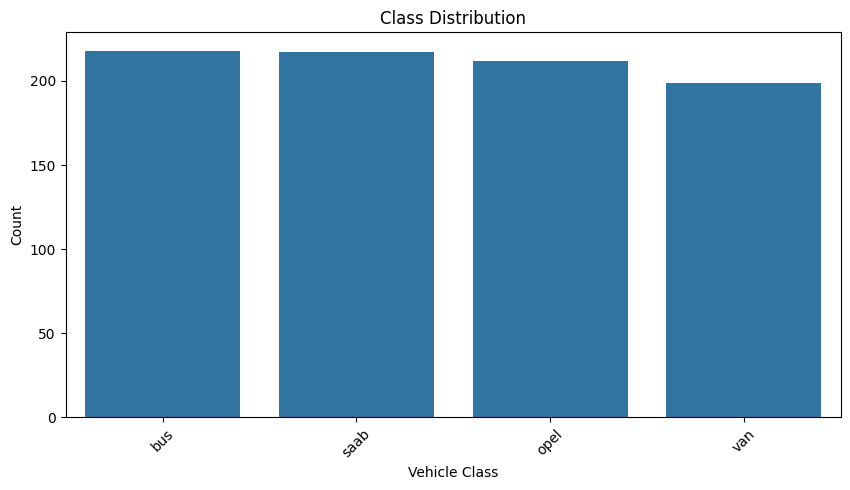


Number of features: 18
Number of data points: 846


In [10]:
import os
data_dir = './vehicle_data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

file_names = [f'xa{chr(ord("a") + i)}.dat' for i in range(9)] 
base_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/vehicle/"

column_names = [f'feat_{i}' for i in range(1, 19)] + ['class']

df_list = []
for fname in file_names:
    file_url = base_url + fname
    file_path = os.path.join(data_dir, fname)
    try:
        if not os.path.exists(file_path):
            import urllib.request
            print(f"Downloading {fname}...")
            urllib.request.urlretrieve(file_url, file_path)
        else:
            print(f"Using cached {fname}...")

        df_part = pd.read_csv(file_path, sep='\s+', header=None, names=column_names)
        df_list.append(df_part)
    except Exception as e:
        print(f"Error processing file {fname}: {e}")

if df_list:
    df = pd.concat(df_list, ignore_index=True)
    print("\nData loaded successfully.")

    print("\nData Info:")
    df.info()
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nData Description:")
    print(df.describe())
    print("\nClass Distribution:")
    print(df['class'].value_counts())

    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x='class', order=df['class'].value_counts().index)
    plt.title('Class Distribution')
    plt.xlabel('Vehicle Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

    num_features = df.shape[1] - 1
    num_data_points = df.shape[0]
    print(f"\nNumber of features: {num_features}")
    print(f"Number of data points: {num_data_points}")
else:
    print("\nFailed to load data.")

## 2. Data Split

In [11]:
X = df.drop('class', axis=1)
y = df['class']

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
num_classes = len(encoder.classes_)
print(f"\nClasses: {encoder.classes_}")
print(f"Encoded labels (first 10): {y_encoded[:10]}")
print(f"Number of classes: {num_classes}")


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print("\nX_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Classes: ['bus' 'opel' 'saab' 'van']
Encoded labels (first 10): [3 3 2 3 0 0 0 3 3 2]
Number of classes: 4

X_train shape: (676, 18)
X_test shape: (170, 18)
y_train shape: (676,)
y_test shape: (170,)


## 3. Data Preprocessing

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nX_train_scaled (first 5 rows):")
print(X_train_scaled[:5])
print("\nX_test_scaled (first 5 rows):")
print(X_test_scaled[:5])


X_train_scaled (first 5 rows):
[[-0.05079568  0.36251949  0.20450376 -0.16424822  0.50937085  0.46864745
  -0.37054146  0.37569927 -0.20741622  0.70127637 -0.5194951  -0.46627596
   0.11464257  0.19280914  0.1407387   0.29229035 -0.95377942 -0.07953398]
 [ 1.78218729  1.99518557  1.54854789  0.24927802 -1.2877831  -0.73213212
   2.67081391 -1.9436862   2.90843637  1.53078262  3.12517719  3.03865153
   2.69274482  1.88891194  0.962677   -1.15728506 -1.1161453  -1.970764  ]
 [-1.0283866  -1.43341319 -0.24351095 -0.57777446 -0.80854204 -0.33187226
  -0.64426345  0.50455402 -0.5968978  -1.37248927 -0.64851005 -0.66131284
  -1.25206224 -1.11188533  0.75719242  1.29584257  1.31934283  1.00116889]
 [-0.53959114 -0.61708015  0.14050165 -0.81407516 -0.44911125  0.06838759
  -0.58343634  0.50455402 -0.5968978  -0.19735541 -0.5194951  -0.60968543
  -0.382341   -0.06812976 -0.47571503  0.62680776 -0.14195005  0.59590532]
 [ 0.43799978 -0.61708015 -1.26754458 -1.05037587 -0.68873178 -0.33187226
  

## 4. Training (ANN)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 64)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,428 (13.39 KB)

 Trainable params: 3,428 (13.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.2681 - loss: 1.5710 - val_accuracy: 0.4044 - val_loss: 1.3095
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4899 - loss: 1.2880 - val_accuracy: 0.5515 - val_loss: 1.1789
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5846 - loss: 1.1484 - val_accuracy: 0.5735 - val_loss: 1.0906
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6199 - loss: 1.0647 - val_accuracy: 0.6471 - val_loss: 1.0019
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6586 - loss: 0.9887 - val_accuracy: 0.6765 - val_loss: 0.9149
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7039 - loss: 0.8854 - val_accuracy: 0.7132 - val_loss: 0.8340
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7216 - loss: 0.8111 - val_accuracy: 0.7206 - val_loss: 0.7723
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7071 - loss: 0.7567 - val_accuracy: 0.

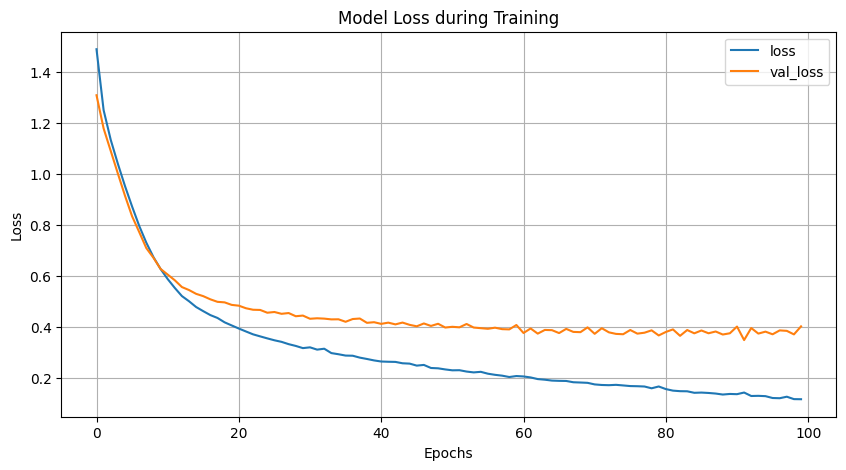

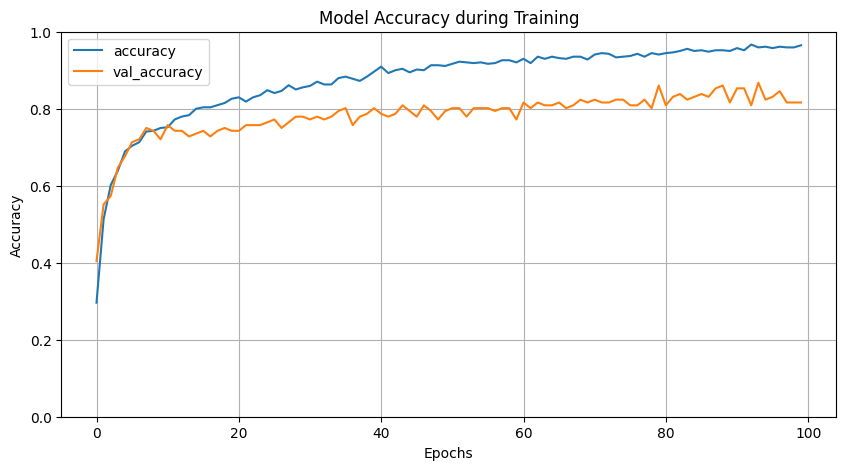

In [13]:
def build_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(64, activation='relu', name='hidden1'),
        
        layers.Dense(32, activation='relu', name='hidden2'),
        
        layers.Dense(num_classes, activation='softmax', name='output')
    ])
    return model

input_shape = (X_train_scaled.shape[1],)
model = build_model(input_shape, num_classes)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

epochs = 100
batch_size = 32

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2, 
                    callbacks=[early_stopping], 
                    verbose=1) 

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(10, 5))
plt.title('Model Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

history_df[['accuracy', 'val_accuracy']].plot(figsize=(10, 5))
plt.title('Model Accuracy during Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.ylim(0, 1)
plt.show()

## 5. Uncertainty Quantification

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Uncertainty Measures (first 10 samples):
MSP (1-max_prob): [3.6709964e-02 3.8375175e-01 3.9901489e-01 7.4165761e-02 3.4682858e-01
 1.7881393e-06 1.2993813e-05 1.2035841e-01 7.7893674e-02 2.0402670e-04]
Entropy: [1.5793300e-01 6.6592592e-01 6.7261028e-01 2.6460439e-01 6.4554679e-01
 2.5005835e-05 1.6121542e-04 3.8966870e-01 2.7360708e-01 1.9672448e-03]
Variance: [0.1698174  0.06925601 0.06759899 0.15316604 0.07422951 0.1874991
 0.1874935  0.134301   0.15158683 0.18739802]


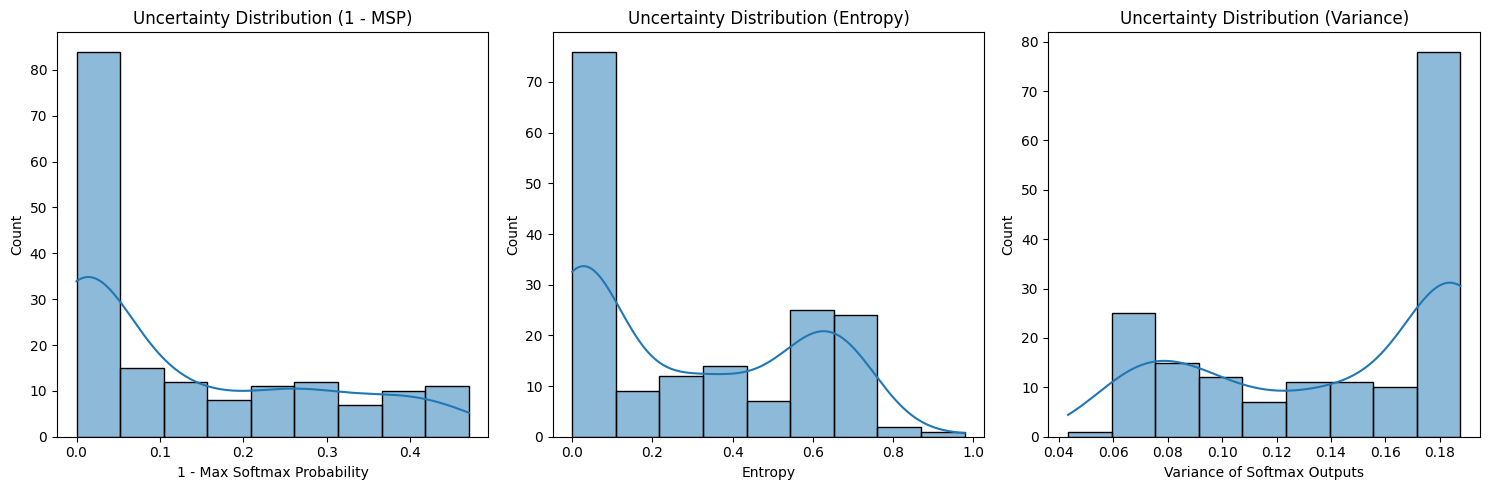

In [14]:
y_pred_proba = model.predict(X_test_scaled)


msp = np.max(y_pred_proba, axis=1)
uncertainty_msp = 1 - msp


epsilon = 1e-10
uncertainty_entropy = scipy.stats.entropy(y_pred_proba + epsilon, axis=1)


uncertainty_variance = np.var(y_pred_proba, axis=1)


print("\nUncertainty Measures (first 10 samples):")
print("MSP (1-max_prob):", uncertainty_msp[:10])
print("Entropy:", uncertainty_entropy[:10])
print("Variance:", uncertainty_variance[:10])


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(uncertainty_msp, kde=True)
plt.title('Uncertainty Distribution (1 - MSP)')
plt.xlabel('1 - Max Softmax Probability')

plt.subplot(1, 3, 2)
sns.histplot(uncertainty_entropy, kde=True)
plt.title('Uncertainty Distribution (Entropy)')
plt.xlabel('Entropy')

plt.subplot(1, 3, 3)
sns.histplot(uncertainty_variance, kde=True)
plt.title('Uncertainty Distribution (Variance)')
plt.xlabel('Variance of Softmax Outputs')

plt.tight_layout()
plt.show()

## 6. Evaluation (without reject option)


--- Evaluation without Reject Option ---
Accuracy: 0.8118

Classification Report:
              precision    recall  f1-score   support

         bus       1.00      1.00      1.00        44
        opel       0.69      0.57      0.62        42
        saab       0.62      0.75      0.68        44
         van       0.97      0.93      0.95        40

    accuracy                           0.81       170
   macro avg       0.82      0.81      0.81       170
weighted avg       0.82      0.81      0.81       170



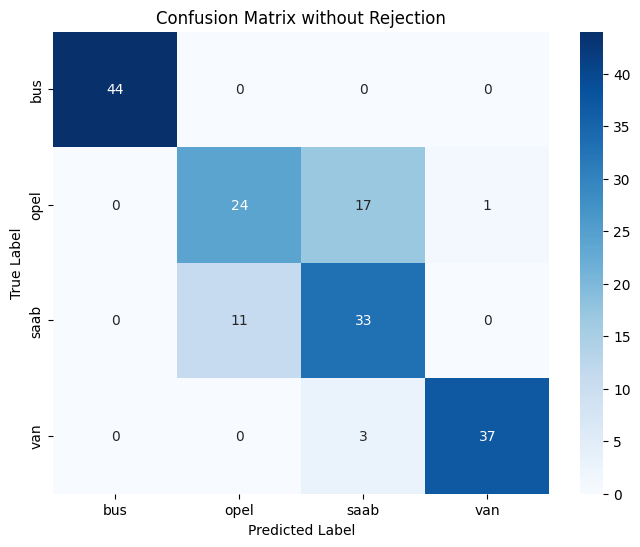

In [15]:
y_pred = np.argmax(y_pred_proba, axis=1)

accuracy_no_reject = accuracy_score(y_test, y_pred)
print(f"\n--- Evaluation without Reject Option ---")
print(f"Accuracy: {accuracy_no_reject:.4f}")

print("\nClassification Report:")

print(classification_report(y_test, y_pred, target_names=encoder.classes_))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix without Rejection')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 7. Evaluation (with reject option)

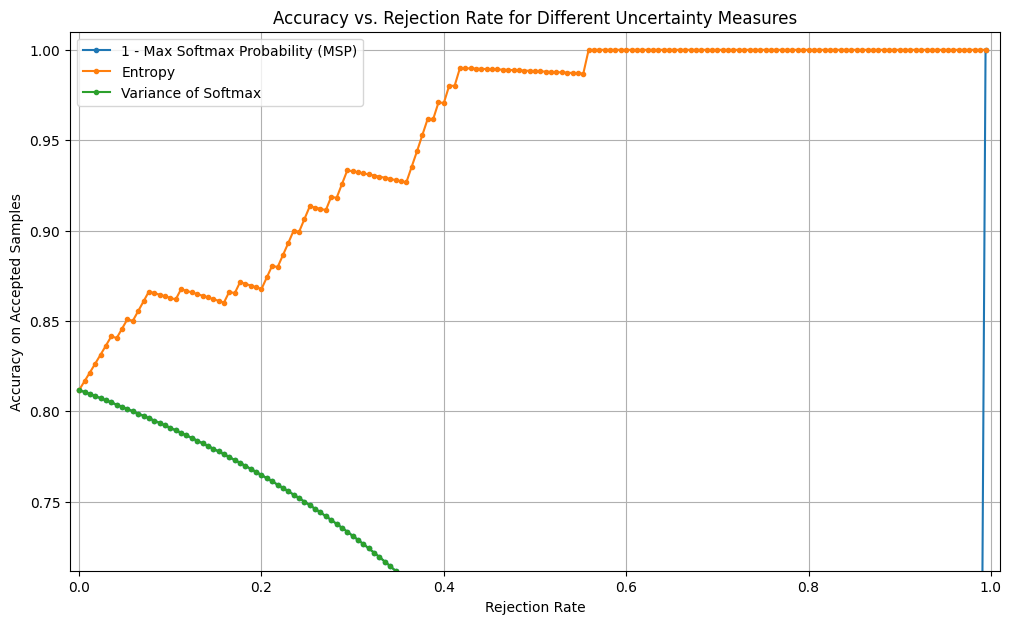

MSP: Best Accuracy = 1.0000 at Rejection Rate = 0.9941
Entropy: Best Accuracy = 1.0000 at Rejection Rate = 0.5588
Variance: Best Accuracy = 0.8118 at Rejection Rate = 0.0000


In [16]:
def evaluate_with_reject(y_true, y_pred_proba, uncertainty_scores, uncertainty_type):
    
    results = []
    n_total = len(y_true)
    y_pred = np.argmax(y_pred_proba, axis=1)

    
    if uncertainty_type == 'low_is_uncertain':
        
        sorted_indices = np.argsort(uncertainty_scores)
    else:
        
        sorted_indices = np.argsort(uncertainty_scores)[::-1]

    for k in range(n_total + 1): 
        rejection_rate = k / n_total
        if k == n_total: 
            accuracy = np.nan
            accepted_count = 0
        else:
            
            reject_indices = sorted_indices[:k]
            
            accept_indices = sorted_indices[k:]
            accepted_count = len(accept_indices)

            
            accepted_y_true = y_true[accept_indices]
            accepted_y_pred = y_pred[accept_indices]

            
            if accepted_count == 0:
                accuracy = np.nan 
            else:
                accuracy = accuracy_score(accepted_y_true, accepted_y_pred)

        results.append({'rejection_rate': rejection_rate, 'accuracy': accuracy, 'accepted_count': accepted_count})

    return pd.DataFrame(results)

results_msp = evaluate_with_reject(y_test, y_pred_proba, uncertainty_msp, 'low_is_uncertain') 
results_entropy = evaluate_with_reject(y_test, y_pred_proba, uncertainty_entropy, 'high_is_uncertain')
results_variance = evaluate_with_reject(y_test, y_pred_proba, uncertainty_variance, 'high_is_uncertain')


plt.figure(figsize=(12, 7))
plt.plot(results_msp['rejection_rate'], results_msp['accuracy'], label='1 - Max Softmax Probability (MSP)', marker='.')
plt.plot(results_entropy['rejection_rate'], results_entropy['accuracy'], label='Entropy', marker='.')
plt.plot(results_variance['rejection_rate'], results_variance['accuracy'], label='Variance of Softmax', marker='.')

plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy on Accepted Samples')
plt.title('Accuracy vs. Rejection Rate for Different Uncertainty Measures')
plt.legend()
plt.grid(True)
plt.xlim(-0.01, 1.01)

plt.ylim(bottom=max(0, accuracy_no_reject - 0.1), top=1.01)
plt.show()



def print_best_accuracy(results_df, method_name):
    best_idx = results_df['accuracy'].idxmax()
    best_accuracy = results_df.loc[best_idx, 'accuracy']
    corresponding_rate = results_df.loc[best_idx, 'rejection_rate']
    print(f"{method_name}: Best Accuracy = {best_accuracy:.4f} at Rejection Rate = {corresponding_rate:.4f}")

print_best_accuracy(results_msp, 'MSP')
print_best_accuracy(results_entropy, 'Entropy')
print_best_accuracy(results_variance, 'Variance')